# **NDSI with MODIS and Dask**

This tutorial notebook demonstrates how to find, visualize, and analyze the Normalized Difference Snow Index with MODIS imagery, efficiently using Dask. The satellite we will be using is the MODIS Terra Surface Reflectance Daily Global 1km and 500m Version 6 (MOD09GA.006) which has a spatial resolution of 500-1000 meters and temporal resolution of 1 day. We will be focusing on the granules covering Northern British Columbia and most of Alberta.

**What is NDSI?**

The Normalized Difference Snow Index is used to detect the presence of snow in a pixel. Identifying snow cover is important for hazard mitigation, and for hydrological and weather forecasting. Snow has very high visible (Green) reflectance and very low reflectance in the shortwave infrared (SWIR), which makes it easy to differentiate snow cover from most cloud types. 

**How is NDSI calculated?**

To calculate NDSI, the Visible Green light band and SWIR band are used in this formula: 

- **`NDSI = (Green - SWIR) / (Green + SWIR)`**

In MOD09GA Version 6, Band 4 is green and Band 6 is SWIR. 

**What do NDSI values represent?**

The NDSI values ranging from 0 to 1, higher values (NDSI > 0.4) represent snow. The MODIS products were tested with different NDSI thresholds ranging from 0.3 to 0.4 to map the snow cover over low-altitude glaciers due to its coarser resolution.



## 1. Initialize your Dask Gateway Clusters
Since we want to use eight years of data for our analysis, running the computation using the cores of the machine we are running this notebook on is not ideal. Let's connect to Dask Gateway so the clusters can run our work on Elastic Compute Cloud (EC2) machines.

For now, we will set our cluster to scale the workers to 20, because of the amount of data we will be working with.

In [127]:
import os
import glob
import re
import datetime
import requests
import sys
import time
import io
import math
import yaml
import tempfile

import dask
import distributed
import rasterio

import pandas as pd
import xarray as xr
import numpy as np
import rioxarray as rxr

from dask.distributed import wait, progress
from rasterio.plot import show
from urllib.request import urlopen, Request, build_opener, HTTPCookieProcessor
from dask_gateway import Gateway

In [68]:
gateway = Gateway()
options = gateway.cluster_options()
cluster = gateway.new_cluster(options)

In [69]:
workers = 20
cluster.scale(workers)

In [70]:
client = cluster.get_client() #Make sure dask knows to use this cluster for computations

In [71]:
#client.wait_for_workers(workers - 27)
cluster

In [72]:
dask.config.set({"dask.comm.timeouts.tcp": "60s"})

## 2. Getting the MODIS Data
In contrast to the Sentinel-2 and Landsat 8 satellite data which are publicly available for download, MODIS data is stored on NASA's Land Processes Distributed Active Archive Center (LP DAAC) located at the USGS Earth Resources Observation and Science (EROS) Center. The data requires a NASA Earthdata Authentication with the user's username and password. (https://e4ftl01.cr.usgs.gov/)

**The main steps to retrieve the MODIS data follow as such:**

1. Using python-cmr, select the desired data based on the Granule Queries.
2. Create an Earthdata Account and store credentials for authentication.
3. Using Hatfield's CMR to access the LP DAAC website with the credentials and stream the data into an in-memory file object. 
4. Assigning a temporary file name to the object and opening the file with rasterio.


### 2.1 Select the Granules

Install the **python-cmr** which is a wrapper to the NASA EOSDIS Common Metadata Repository API. The package allows you to make queries on the available data.

In [8]:
! pip install python-cmr

Next we will set the parameters of our search to get the granules for the product "MOD09GA" of version 6, with the tile Horizontal 10 and Vertical 3 (indicated by the latitude, longitude point inside that tile) from 2016 to 2021. 

In [96]:
# Time period 
start_date = datetime.datetime(2016, 6, 30).date()
end_date = datetime.datetime(2021, 6, 30).date()

In [97]:
from cmr import GranuleQuery

# search for MOD09GA version 006 granules at latitude 56, longitude -120
api = GranuleQuery()
api.parameters(
    short_name="MOD09GA",
    version="006",
    point=(-120, 51), # within Tile H10V3 - encompasses northern BC area
    temporal=(f"{start_date}T00:00:00Z", f"{end_date}T23:59:59Z")
)

Now we will retrieve all the granules possible for the queries using the `.get_all()` method. 

In [98]:
granules = api.get_all()
len(granules)

1827

In [99]:
granules[0]['links'][0]['href']

'https://e4ftl01.cr.usgs.gov//DP109/MOLT/MOD09GA.006/2016.06.30/MOD09GA.A2016182.h10v03.006.2016187214710.hdf'

### 2.2 Create an EarthData Account
To download MODIS data, you will require an Earthdata account for access. Head over to https://urs.earthdata.nasa.gov/ and create a free account!

Once you have created your account, store your credentials for the Hatfield CMR to use when authenticating for data download. 

**1. Create a yaml file, 'ED_config.yml' within your data folder and store your credentials as such, substituting your username and password in place:**

   - `EARTHDATA_USER: '<username>'`
   - `EARTHDATA_PASS: '<password>'`
   
**2. Run the cell below to load and pass in the credentials as a tuple to `auth`.**


In [77]:
# Load the yaml file containing the authentication to EarthData
envvars = open('data/ED_config.yml' ,'r')
secrets = yaml.load(envvars, Loader=yaml.FullLoader)
envvars.close()
auth=(secrets['EARTHDATA_USER'],secrets['EARTHDATA_PASS'])

### 2.3 Hatfield CMR

Use the Hatfield CMR functions to safely access the granules and load them as an in-memory file.

In [100]:
from typing import Tuple, List 
import requests
from html.parser import HTMLParser

class LinkFinder(HTMLParser):
    def __init__(self):
        super().__init__()
        self.download_link = None

    def handle_starttag(self, tag, attrs):
        if attrs and attrs[0][0] == 'href':
            self.download_link = attrs[0][1]

            
class SessionWithHeaderRedirection(requests.Session):
    AUTH_HOST = 'urs.earthdata.nasa.gov'
    def __init__(self, auth):
        super().__init__()
        # auth = (username, password)
        self.auth = auth

   # Overrides from the library to keep headers when redirected to or from
   # the NASA auth host.
    def rebuild_auth(self, prepared_request, response):
        headers = prepared_request.headers
        url = prepared_request.url
        if 'Authorization' in headers:
            original_parsed = requests.utils.urlparse(response.request.url)
            redirect_parsed = requests.utils.urlparse(url) 
            if (original_parsed.hostname != redirect_parsed.hostname) and redirect_parsed.hostname != self.AUTH_HOST and original_parsed.hostname != self.AUTH_HOST:
                del headers['Authorization']
        return

#@dask.delayed
def get_session(auth, retries=5):
    # s = requests.Session()
    s = SessionWithHeaderRedirection(auth)
    #r = Retry(total=retries, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504])
    # s.mount('http://', HTTPAdapter(max_retries=r))
    #s.mount('https://', HTTPAdapter(max_retries=r))
    return s

#@dask.delayed
def get_stream(session, url, auth, previous_tries):
    """ Traverse redirects to get the final url """

    # stream = session.get(url, auth=auth, stream=True)
    stream = session.get(url,
                         auth=auth,
                         allow_redirects=True,
                         stream=True)

    # if we get back to the same url, it's time to download
    if url in previous_tries or stream.status_code == 200:
        return stream

    if stream.status_code == 302:
        # if stream.status_code != 200:
        #     print(f"Error getting response {stream.status_code} {stream.text}")
        previous_tries.append(url)
        link = LinkFinder()
        link.feed(stream.text)
        return self.get_stream(session, link.download_link, auth,
                               previous_tries)
    else:
        raise RuntimeError(
            f"Earthdata Authentication Error {stream.status_code} {stream.text}"
        )
    # return stream

def download_earthdata_file(url: str,
                           auth: tuple,
                           noauth: bool = False) -> io.BytesIO:
    session = get_session(auth, retries=5)
    if noauth:
        stream = session.get(url, stream=True)
    else:
        stream = get_stream(session, url, auth, [])
    buf = io.BytesIO()
    for chunk in stream.iter_content(256 * 1024):
        buf.write(chunk)
    buf.seek(0,0)
    return buf

## 3. Calculating the NDSI

Now that we have the functions ready, let's access the data and compute the NDSI! To efficiently get the NDVI for all the data, we must first load in the MODIS image data from NASA's LPDAAC Center, using Hatfield's CMR. 

### 3.1 Stream and Load the MODIS Data

Let's run the cells below to generate the functions to lazily retrieve the data from NASA servers. The function `lazy_get_data()` takes in the url of an image from the list of granules, along with the Earthdata authentication and the Dask chunk sizes. 

The url will be used to download the file as a temporary file using the Hatfield CMR, and opened using rasterio. Since the MODIS tiles cover a large area on Earth, we will be looking at only one portion for our NDSI analysis. The rasterio `window` will only read the part of the tile we specify. In this example, the window covers Southern British Columbia, near the Rocky Mountains.

We will convert the "windowed" numpy arrays from rasterio to dask arrays with the assigned chunksize, for optimal parallelization.

In [79]:
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

In [101]:
@dask.delayed
def lazy_get_data(url, auth, chunks={'band': 1, 'x': 2048, 'y': 2048}):
    
    buff = download_earthdata_file(url, auth) # download the image into memory
    with tempfile.NamedTemporaryFile() as tmpfile:
        tmpfile.write(buff.getvalue())
        with rasterio.open(tmpfile.name, 'r') as modis_scene:
            B4 = modis_scene.subdatasets[6]
            B6 = modis_scene.subdatasets[8]

            with rasterio.open(B4) as green, rasterio.open(B6) as swir:
                # window(row_offset, col_offset, width, height)
                window = rasterio.windows.Window(700, 1500, 1700, 900)
                
                # read only the section specified by the window  and change to float type              
                green1 = green.read(window=window).astype('float64').squeeze()
                swir1 = swir.read(window=window).astype('float64').squeeze()
                
                # Convert numpy array to dask array in chunks
                green_da = dask.array.from_array(green1, chunks=chunks)
                swir_da = dask.array.from_array(swir1, chunks=chunks)

    return (green_da, swir_da)

### 3.2 Calculate the NDSI of each granule

With the bands ready for computation, we can now construct the main function for calculating the NDSI of each raster. The function `get_NDSI()` computes the NDSI using the input bands and transforms the resulting array into an Xarray DataArray with the dimensions, x and y. 

In [102]:
@dask.delayed
def get_NDSI(green, swir):
    # Compute the NDSI and return the resulting array into an Xarray DataArray
    NDSI = (green - swir) / (green + swir)
    #print(NDSI.load())
    NDSI_da = xr.DataArray(NDSI, dims=['y','x'])
    #NDSI_da = xr.DataArray(NDSI)

    return NDSI_da

Now, the code blocks underneath call the functions above to append the resulting Dask.delayed objects into a list, then computing and persisting the results to the cluster in parallel.

In [103]:
%%time

delayed_downloads = []
dates_arr = []    
for file in granules[::3]:
    url = file['links'][0]['href']
    # Add the date to the dates list
    get_date = re.search('\d{4}\d{3}', url)
    date = datetime.datetime.strptime(get_date.group(), '%Y%j').date()
    dates_arr.append(date)
    
    delayed_downloads.append(lazy_get_data(url, auth))
    

CPU times: user 40.5 ms, sys: 2.12 ms, total: 42.6 ms
Wall time: 40.5 ms


In [104]:
delayed_ndsi = []
for band in delayed_downloads:
    delayed_ndsi.append(get_NDSI(band[0], band[1]))

In [105]:
len(delayed_ndsi)

609

In [106]:
%%time
ndsi_arr = []
for i in delayed_ndsi:
    ndsi_arr.append(i.persist())

CPU times: user 754 ms, sys: 43.1 ms, total: 797 ms
Wall time: 752 ms


In [107]:
progress(ndsi_arr)

VBox()

In [108]:
%%time
final_ndsi_arrs = [i.compute().persist() for i in ndsi_arr]
#final_ndsi_arrs

CPU times: user 32.6 s, sys: 8.12 s, total: 40.7 s
Wall time: 2min


### 3.3 Combine the NDSI of all granules together in one DataArray

The next step is to concatenate the list of DataArrays from the previous step with their respective dates into a Xarray DataArray.

In [109]:
final_ndsi = xr.concat(final_ndsi_arrs, dim=pd.DatetimeIndex(dates_arr, name='time'))
final_ndsi

<xarray.DataArray 'truediv-ffd315603b16337c7e67d0e606d92a44' (time: 609, y: 900, x: 1700)>
dask.array<concatenate, shape=(609, 900, 1700), dtype=float64, chunksize=(1, 900, 1700), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-06-30 2016-07-03 ... 2021-06-28
Dimensions without coordinates: y, x

## 4. Visualizing the Results

Now, let's visualize our NDSI in a monthly average over the 6 years. Instead of using HoloViz's **hvplot** as we have done in the NDVI and NDWI with Dask notebooks, let's use Xarray's plotting powers to display our results. 

The cell below iteratively creates a monthly mean for each year

In [139]:
years = np.arange(2016, 2022, 1)

years_list = []
for i in years:
    i = final_ndsi.sel(time=final_ndsi.time.dt.year.isin(i)).groupby('time.month').mean('time')
    years_list.append(i)

years_list

[<xarray.DataArray 'truediv-ffd315603b16337c7e67d0e606d92a44' (month: 7, y: 900, x: 1700)>
 dask.array<stack, shape=(7, 900, 1700), dtype=float64, chunksize=(1, 900, 1700), chunktype=numpy.ndarray>
 Coordinates:
   * month    (month) int64 6 7 8 9 10 11 12
 Dimensions without coordinates: y, x,
 <xarray.DataArray 'truediv-ffd315603b16337c7e67d0e606d92a44' (month: 12, y: 900, x: 1700)>
 dask.array<stack, shape=(12, 900, 1700), dtype=float64, chunksize=(1, 900, 1700), chunktype=numpy.ndarray>
 Coordinates:
   * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
 Dimensions without coordinates: y, x,
 <xarray.DataArray 'truediv-ffd315603b16337c7e67d0e606d92a44' (month: 12, y: 900, x: 1700)>
 dask.array<stack, shape=(12, 900, 1700), dtype=float64, chunksize=(1, 900, 1700), chunktype=numpy.ndarray>
 Coordinates:
   * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
 Dimensions without coordinates: y, x,
 <xarray.DataArray 'truediv-ffd315603b16337c7e67d0e606d92a44' (month: 12, y: 900, x: 170

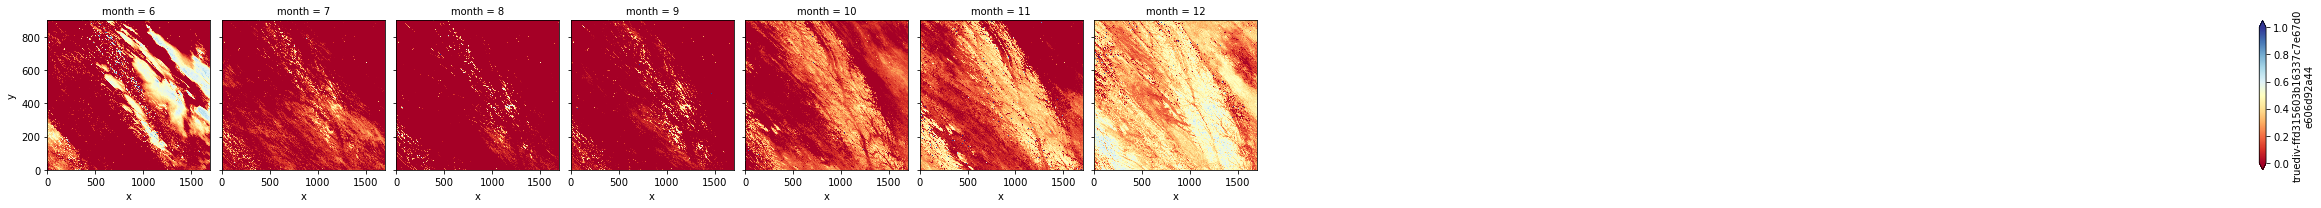

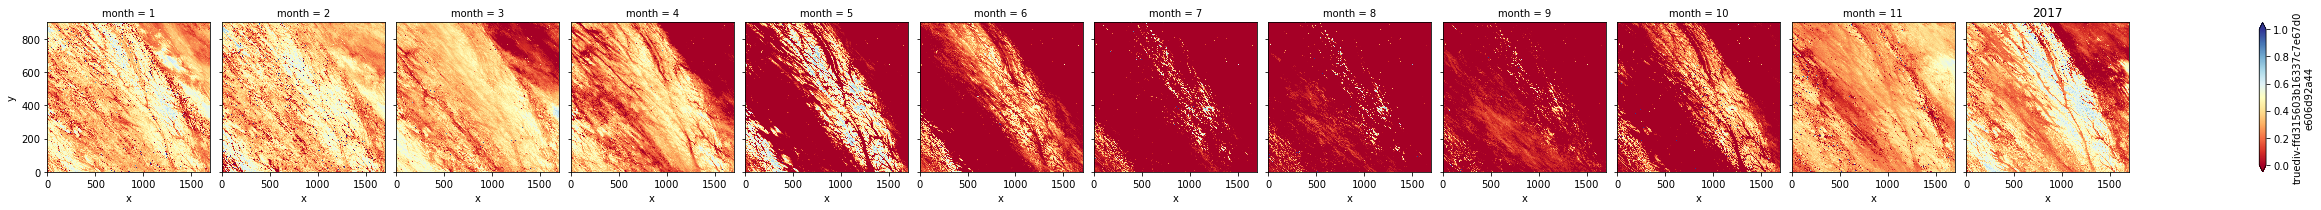

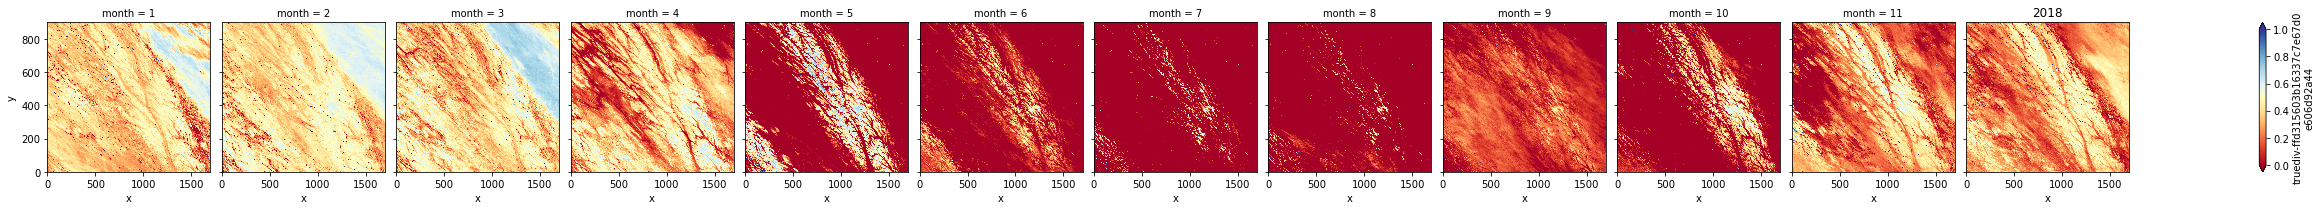

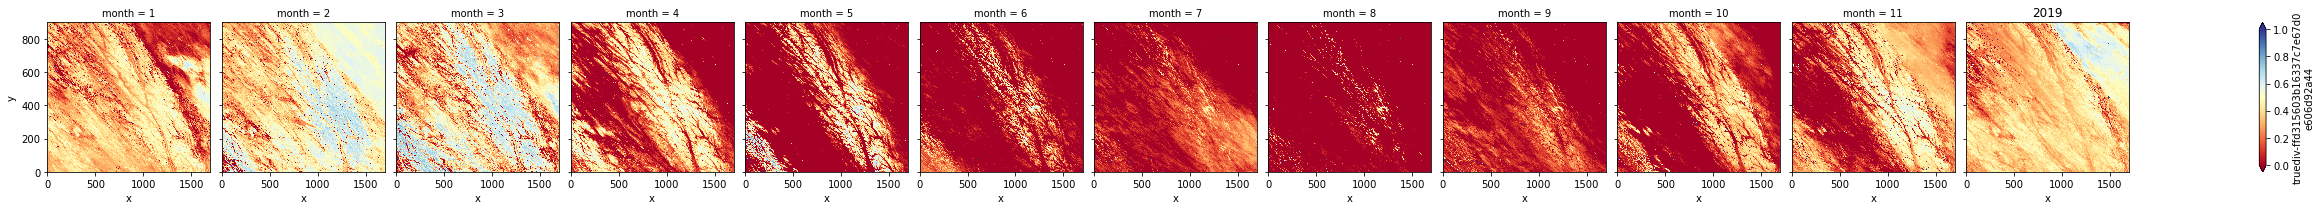

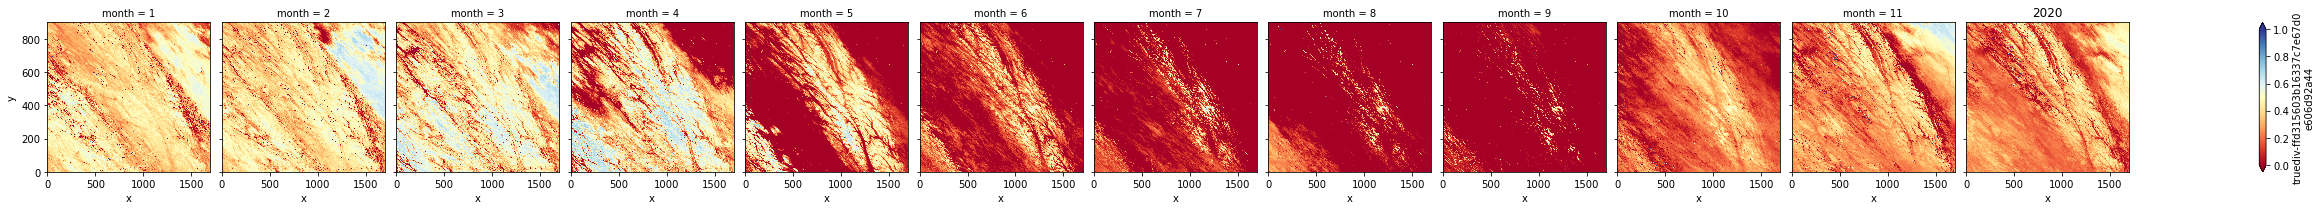

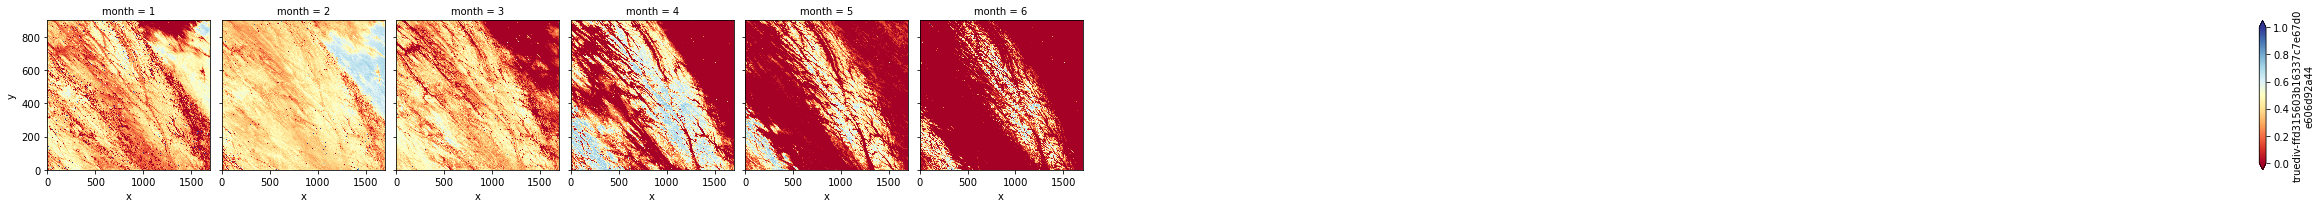

In [142]:
for i in range(len(years_list)):
    years_list[i].plot.imshow('x', 'y', col='month', vmin=0, vmax=1, col_wrap=12, cmap='RdYlBu')
    plt.title(years[i])

In [66]:
%%time

# Creates gif 
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

def animate(i):
    ax.imshow(final_ndsi_arrs[i], cmap='RdYlBu', clim=(0,1))
    ax.set_title("Date: {}".format(dates_arr[i]), fontsize=30)
    ax.set_axis_off()

anim = FuncAnimation(fig, animate, frames=np.arange(len(final_ndsi_arrs)), interval=80)
anim.save('NDSI_anim_2016-366.gif', dpi=50, writer='pillow')
plt.close()


CPU times: user 2h 13min 41s, sys: 28 s, total: 2h 14min 9s
Wall time: 2h 14min 9s


In [65]:
len(final_ndsi_arrs)

366

***Make sure to always explicitly shut down computing resources when you're not using them!***

In [143]:
cluster.close()